# Comparaison de performences de l'image captioning entre llava, moondream et qwen2.5vl:3b.

On compare diférents modèles selon les métriques CIDER, BLEU, SPICE, CHAIR et METEOR sur des images de COCO val2017.

### Les resultats ainsi qu'une courte analyse de la simulation sont disponible à la fin de notebook

In [9]:

import pickle
import os
from pathlib import Path
from dotenv import load_dotenv
from evaluation.Scorer import Scorer
from core.Model import Model
import time
import gc
load_dotenv()
!ollama list

NAME                ID              SIZE      MODIFIED     
qwen2.5vl:3b        fb90415cde1e    3.2 GB    3 days ago      
moondream:latest    55fc3abd3867    1.7 GB    3 days ago      
llava:latest        8dd30f6b0cb1    4.7 GB    2 months ago    


In [10]:
PROMPTS = [
    "Provide a very short, concise, and factual caption for this image. Maximum 10 words."
]

# Images
dataset_root = Path(os.getenv("DATASET_PATH", "."))
IMG_FOLDER = dataset_root / "val2017"
NUM_IMG = 1000
print(IMG_FOLDER)
IMGS_PATH = list(IMG_FOLDER.rglob('*.jpg'))[:NUM_IMG]
print(IMGS_PATH)
# Test images
IMG_TEST_PATH = IMGS_PATH[0]
IMG_TEST_ID = int(Path(IMG_TEST_PATH).stem)

# CHAIR
PATH_INSTANCES = dataset_root / "annotations/instances_val2017.json"

print(PATH_INSTANCES)
PATH_SYNONYMS = "data/our_data/coco_synonyms_SOTA.txt"

models_list = os.getenv("AVAILABLE_MODELS", "").split(",")
print(models_list)

C:\Users\bogae\Desktop\NLP\data\coco\val2017
[WindowsPath('C:/Users/bogae/Desktop/NLP/data/coco/val2017/000000000139.jpg'), WindowsPath('C:/Users/bogae/Desktop/NLP/data/coco/val2017/000000000285.jpg'), WindowsPath('C:/Users/bogae/Desktop/NLP/data/coco/val2017/000000000632.jpg'), WindowsPath('C:/Users/bogae/Desktop/NLP/data/coco/val2017/000000000724.jpg'), WindowsPath('C:/Users/bogae/Desktop/NLP/data/coco/val2017/000000000776.jpg'), WindowsPath('C:/Users/bogae/Desktop/NLP/data/coco/val2017/000000000785.jpg'), WindowsPath('C:/Users/bogae/Desktop/NLP/data/coco/val2017/000000000802.jpg'), WindowsPath('C:/Users/bogae/Desktop/NLP/data/coco/val2017/000000000872.jpg'), WindowsPath('C:/Users/bogae/Desktop/NLP/data/coco/val2017/000000000885.jpg'), WindowsPath('C:/Users/bogae/Desktop/NLP/data/coco/val2017/000000001000.jpg'), WindowsPath('C:/Users/bogae/Desktop/NLP/data/coco/val2017/000000001268.jpg'), WindowsPath('C:/Users/bogae/Desktop/NLP/data/coco/val2017/000000001296.jpg'), WindowsPath('C:/Us

## UTILS

Load captions for each picture.

In [11]:
CAPTIONS_MAP_PATH = Path("data\our_data\captions_map.pkl")

if not os.path.exists(CAPTIONS_MAP_PATH):
    print("Fichier introuvable.")
else:
    with open(CAPTIONS_MAP_PATH, "rb") as f:
        coco_captions = pickle.load(f)
        print(f"ground truth captions loaded : {len(coco_captions)}")

ground truth captions loaded : 5000


<>:1: SyntaxWarning: invalid escape sequence '\o'
<>:1: SyntaxWarning: invalid escape sequence '\o'
C:\Users\bogae\AppData\Local\Temp\ipykernel_12260\2378847141.py:1: SyntaxWarning: invalid escape sequence '\o'
  CAPTIONS_MAP_PATH = Path("data\our_data\captions_map.pkl")


# Model

In [12]:
model_inst = {}

#print(model_inst)


# METRIQUES

In [13]:

scorer = Scorer(path_instances=PATH_INSTANCES, path_synonyms=PATH_SYNONYMS)
print(scorer.java_path)

C:\Users\bogae\Documents\java8\jdk8u472-b08\bin\java.exe


In [14]:
for i  in model_inst:
    print(i)


In [15]:
!java -version

openjdk version "25.0.1" 2025-10-21 LTS
OpenJDK Runtime Environment Temurin-25.0.1+8 (build 25.0.1+8-LTS)
OpenJDK 64-Bit Server VM Temurin-25.0.1+8 (build 25.0.1+8-LTS, mixed mode, sharing)


In [16]:
model_scores = {}
for name in models_list:
    gc.collect()
    print(f"start of model :{name}")
    model = Model(model_name=name, prompts=PROMPTS, imgs_path=IMGS_PATH, coco_captions=coco_captions)

    model_scores[name] = {}

    start_time = time.time()
    model_responses, gt_captions_dict = model.execute(prompt_id=0, freq_print=0)

    print(f"DEBUG - Res sample: {list(model_responses.values())[:2]}")
    results = scorer.compute_scores(gt_captions_dict, model_responses)
    duration = time.time() - start_time
    model_scores[name] = {
            metric: score
            for metric, score in results.items()
            if metric not in ['Bleu_2', 'Bleu_3', 'Bleu_4']
        }
    model_scores[name]['Execution_Time'] = round(duration/NUM_IMG, 2)
    del model
    gc.collect()
    print(f"End model: {name}")

start of model :llava
--- Starting analysis. Selected images : 1000 ---
DEBUG - Res sample: [['Empty room in open floor plan.'], ['Bear on green grass.']]
Calcul de CIDEr...
Calcul de Bleu...
{'testlen': 5412, 'reflen': 8584, 'guess': [5412, 4412, 3412, 2415], 'correct': [3626, 1074, 246, 50]}
ratio: 0.6304753028890225
Calcul de METEOR...
Calcul de SPICE...
Calcul de CHAIR...
End model: llava
start of model :moondream
--- Starting analysis. Selected images : 1000 ---
DEBUG - Res sample: [['urn of pink flowers sits on table in living room with yellow walls and wooden floors.'], ['']]
Calcul de CIDEr...
Calcul de Bleu...
{'testlen': 9551, 'reflen': 10546, 'guess': [9551, 8762, 8008, 7255], 'correct': [4746, 1654, 587, 218]}
ratio: 0.905651431822406
Calcul de METEOR...
Calcul de SPICE...
Calcul de CHAIR...
End model: moondream
start of model :qwen2.5vl:3b
--- Starting analysis. Selected images : 1000 ---
Erreur sur l'image C:\Users\bogae\Desktop\NLP\data\coco\val2017\000000032861.jpg: an 

In [17]:
print(model_scores)

{'llava': {'CIDEr': np.float64(0.5568460878446483), 'Bleu_1': 0.3728446067851844, 'METEOR': 0.09495548961424333, 'SPICE': np.float64(0.148710461532805), 'CHAIR': 0.17738970588235295, 'Execution_Time': 0.52}, 'moondream': {'CIDEr': np.float64(0.2976394606606853), 'Bleu_1': 0.44774953522368577, 'METEOR': 0.22288153575628225, 'SPICE': np.float64(0.09849618897699532), 'CHAIR': 0.22136422136422138, 'Execution_Time': 2.05}, 'qwen2.5vl:3b': {'CIDEr': np.float64(1.057452794916665), 'Bleu_1': 0.6719555358935059, 'METEOR': 0.4523423370096794, 'SPICE': np.float64(0.19967665495856285), 'CHAIR': 0.1642512077294686, 'Execution_Time': 0.81}}


In [18]:
import matplotlib.pyplot as plt
import math

def plot_model_comparison(model_scores):
    # On récupère toutes les métriques disponibles
    first_key = next(iter(model_scores))
    metrics = [k for k in model_scores[first_key].keys()]

    model_names = list(model_scores.keys())
    x_labels = model_names

    n_metrics = len(metrics)
    n_cols = 2
    n_rows = math.ceil(n_metrics / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows))

    # Gestion du cas où il n'y a qu'une seule métrique (axes n'est pas une liste)
    if n_metrics == 1:
        axes = [axes]
    else:
        axes = axes.flatten()

    for i, metric in enumerate(metrics):
        ax = axes[i]
        scores = [model_scores[m_name][metric] for m_name in model_names]



        is_time = "Time" in metric or "temp" in metric.lower()
        color = 'lightcoral' if is_time else 'skyblue'

        bars = ax.bar(x_labels, scores, color=color, edgecolor='black')

        # Titre et Label
        title_suffix = " (Secondes)" if is_time else ""
        ax.set_title(f"{metric}{title_suffix}", fontsize=14, fontweight='bold')
        ax.set_ylabel("Temps (s)" if is_time else "Score")

        ax.grid(axis='y', linestyle='--', alpha=0.7)


        for bar in bars:
            height = bar.get_height()
            # On affiche 2 décimales pour les scores, 3 pour le temps par image
            fmt = '.3f' if "per_Img" in metric else '.2f'
            ax.text(bar.get_x() + bar.get_width() / 2., height,
                    f'{height:{fmt}}',
                    ha='center', va='bottom', fontsize=10, fontweight='bold')

    # Supprimer les graphiques vides si n_metrics est impair
    for i in range(n_metrics, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

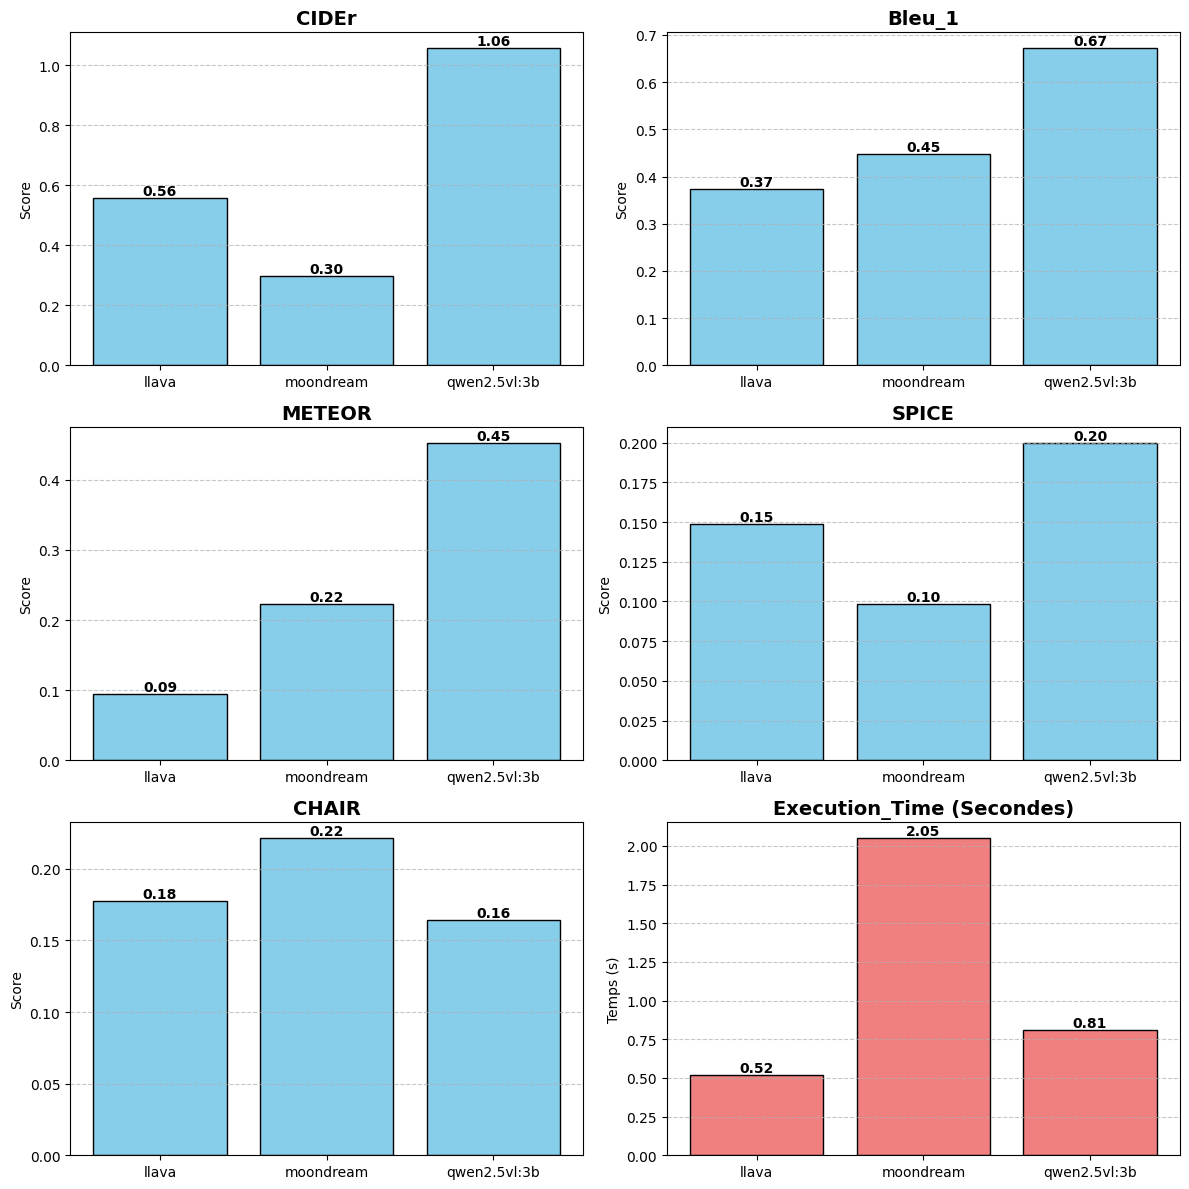

In [19]:
plot_model_comparison(model_scores)

# Analyse des resultats : Comparaison de modèles (LLaVA, Moondream, Qwen)

## Metriques utilisées : 

### Métriques de similarité : 

* CIDEr (Consensus-based Image Description Evaluation) : 
        Utilise une approche TF-IDF pour donner plus de poids aux mots importants et moins aux mots courants. 
        Elle mesure à quel point la légende générée capture le "consensus" des références humaines.
        Métrique standard dans les compétitions de captioning (comme COCO)

* BLEU (Bilingual Evaluation Understudy) :
        Compte le nombre de séquences de mots (n-grammes) qui apparaissent à la fois dans la légende générée et dans la référence. 
        Mesure de précision. Peu fiable car ne reconnaît pas les synonymes.

* METEOR : 
        Corrige la rigidité de BLEU. Prend en compte les correspondances exacts, mais aussi le stemming (racine des mots) et les synonymes.
        Additionellement il regarde l'order des mots pour évaluer sur le sens de la phrase : "Le chat mange la souris" vs "La souris mange le chat".
        Charge les synonymes via WordNet ce qu'il fait via Java.

* SPICE (Semantic Propositional Image Caption Evaluation) :
        transforme les captions (ground truth et response) en "graphes de scène" et compare ensuite ces graphes.


### Métrique d'hallucination

* CHAIR (Caption Hallucination Assessment with Image Relevance)
        : C'est une métrique spécialisée pour détecter les hallucinations. 
        Elle calcule le pourcentage d'objets mentionnés dans la légende qui ne sont pas présents dans l'image 
        (basé sur la liste d'objets connus par exemple grace une segmentation).

### Note : SPICE conssomme énormément de RAM, on a donc dû se limiter sur la simulation et notamment forcer le modèle à faire des descriptions courtes.

## Prompt unique :

*  "Provide a very short, concise, and factual caption for this image. Maximum 10 words."

## Analyse :

### Qwen domine

* Le modèle Qwen2.5-VL:3b surclasse très largement ses concurrents. Avec un score CIDEr de 1.06, il double presque le score de LLaVA (0.56) et triple celui de Moondream (0.30). Cette supériorité se confirme sur toutes les métriques de similarité (Bleu_1 à 0.67, METEOR à 0.45, SPICE à 0.20).

* Qwen semble être le modèle le mieux "aligné" avec la tâche de description courte et factuelle.

### Moondream vs LLaVA

* LLaVA l'emporte sur la structure globale et le sens profond (meilleur CIDEr 0.56 vs 0.30 et meilleur SPICE 0.15 vs 0.10).

* Moondream obtient de meilleurs scores sur les correspondances de mots simples (Bleu_1 0.45 vs 0.37) et la gestion des synonymes/racines (METEOR 0.22 vs 0.09).

* Moondream semble capable de trouver les bons mots clés isolés (d'où le bon Bleu/Meteor), mais peine à assembler des phrases qui capturent le "consensus" descriptif (faible CIDEr) ou les relations sémantiques complexes (faible SPICE) par rapport à LLaVA.

### Hallucinations : CHAIR 
La métrique CHAIR évalue le taux d'objets mentionnés par le modèle mais absents de l'image (un score plus bas est meilleur).

* Qwen est le modèle qui hallucine le moins. Il respecte le mieux la contrainte de "factualité" imposée par le prompt (0.16).

* Moondream semble avoir tendance à inventer des objets ou à mal identifier des éléments visuels plus fréquemment que les deux autres (0.22).

### Performences : temps d'exécution

* LLaVA est extrêmement performant en vitesse (0.52s par image), ce qui en fait un excellent candidat pour du temps réel.

* Moondream est le plus lent (2.05s), presque 4 fois plus lent que LLaVA sur cette tâche spécifique, pourtant on le considère comme un petit modèle.

* Qwen offre un excellent compromis (0.81s) surtout au vu de sa qualité.

## Conclusion : 

* Pour cette tâche spécifique (factualité, précision) Qwen2.5-VL est le modèle le plus performent des trois. LLaVA peut s'averer utile si le temps d'execution est une contrainte importante.